# Stock value prediction from Open, High, Low

# Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects

from collections import deque
from io import StringIO

Using TensorFlow backend.


# Input parameters 

In [2]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 200

neurons_layer = 1
optimizer = 'Adam'
loss = 'mse'
action = 'predict'
# loss = 'risk_estimation'

# 1. Download data and normalize it
Data since date 'start' to today

In [3]:
def normalize_df(df):
    yesterday_value = pd.concat([df[:1], df[:len(df)-1]], ignore_index=True)
    df = pd.concat([df[:]], ignore_index=True)
    df = df / yesterday_value
    return df

def denormalize(origin_value, normalized_p):
    yesterday_value = np.concatenate((origin_value[:1], origin_value[:len(origin_value)-1]))
    normalized_value = normalized_p * yesterday_value
    return normalized_value

In [4]:
import dateutil.parser
def get_last_date(stock_name):
    data_path = 'data/' + stock_name
    if os.path.exists(data_path):
        with open(data_path, 'r') as f:
            last_day_string = deque(f, 1).pop().split(",")[0]
            start = datetime.datetime.strptime(last_day_string, '%Y-%m-%d') + datetime.timedelta(days=1)
            start = start.date()
            return start
    else:
        return datetime.datetime(2013, 1, 1).date()

def update_stock_data(stock_name):
    start = get_last_date(stock_name)
    end = datetime.date.today()
    data_path = 'data/' + stock_name
    
    if os.path.exists(data_path):
        with open(data_path, 'r') as f:
            last_day_string = deque(f, 1).pop().split(",")[0]
            start = datetime.datetime.strptime(last_day_string, '%Y-%m-%d')
            start = start.date()

    if start > datetime.date.today():
        print ('stock data already latest')
        return
    else:
        try:
            df = web.DataReader(stock_name, "yahoo", start)
        except:
            print('retrying data from yahoo...')
            update_stock_data(stock_name)
            return
        
        if os.path.exists(data_path):
            with open(data_path, 'a') as f:
#                 print('df = ',df, 'start = ', start)
                mask = df.index > str(start)
                df = df[mask]
                df.to_csv(f, header=False)
                print ('stock data appended')
        else:
            df.to_csv(data_path)
            print ('stock data create')
        
                
def get_stock_data(stock_name):
    data_path = 'data/' + stock_name
    df = pd.read_csv(os.path.join(data_path))
    
    df.drop(['Volume', 'Close', 'Date'], 1, inplace=True)
    return df

In [5]:
update_stock_data(stock_name)
origin_df = get_stock_data(stock_name)
df = normalize_df(origin_df)

stock data appended


# 2. Plot out the Normalized Adjusted close price

In [6]:
def plot_stock(df):
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

          Open         High          Low    Adj Close
0  1402.430054  1426.739990  1398.109985  1426.189941
1  1426.189941  1462.430054  1426.189941  1462.420044
2  1462.420044  1465.469971  1455.530029  1459.369995
3  1459.369995  1467.939941  1458.989990  1466.469971
4  1466.469971  1466.469971  1456.619995  1461.890015


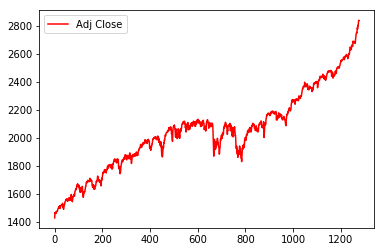

       Open      High       Low  Adj Close
0  1.000000  1.000000  1.000000   1.000000
1  1.016942  1.025015  1.020084   1.025403
2  1.025403  1.002079  1.020572   0.997914
3  0.997914  1.001685  1.002377   1.004865
4  1.004865  0.998999  0.998376   0.996877


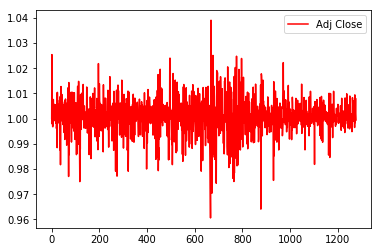

          Open         High          Low    Adj Close
0  1402.430054  1426.739990  1398.109985  1426.189941
1  1426.189941  1462.430054  1426.189941  1462.420044
2  1462.420044  1465.469971  1455.530029  1459.369995
3  1459.369995  1467.939941  1458.989990  1466.469971
4  1466.469971  1466.469971  1456.619995  1461.890015


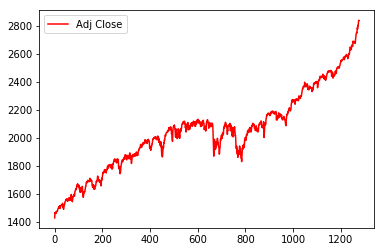

In [7]:
plot_stock(origin_df)
plot_stock(df)
plot_stock(denormalize(origin_df,df))

# 3. Slice data for training

In [8]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length + 1): # maxmimum date = lastest date - sequence length + 1
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    X_train = result[:int(row), :] # 90% date
    y_train = result[1:int(row) + 1, :, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row): -1 , :]
    y_test = result[int(row) + 1: , -1][:,-1] 
    
    x_for_predict = result[-1:  , :]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))
    x_for_predict = np.reshape(x_for_predict, (x_for_predict.shape[0], x_for_predict.shape[1], amount_of_features))
    
    return [X_train, y_train, X_test, y_test, x_for_predict]

In [9]:
X_train, y_train, X_test, y_test, x_for_predict = load_data(df, seq_len)
origin_X_Train, origin_y_Train, origin_X_test, origin_y_test, origin_x_for_predict = load_data(origin_df, seq_len)

print(X_train.shape[0], X_train.shape[1], X_train.shape[2])
print(y_train.shape[0])

1130 22 4
1130


# 4. Buidling neural network

In [10]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    for i in range(neurons_layer):
        model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))

    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# 5. Plot function

In [11]:
def plot_value(stock_name, predict, actual, dir_name, file_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)
    
    fig_path = dir_name + '/' + file_name
    
    plt2.plot(predict, color='red', label='Prediction')
    plt2.plot(actual,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.savefig(fig_path, format='png', bbox_inches='tight', transparent=True)
    plt2.close('all')

In [12]:
# 損益計算、價錢預測
def plot_result(stock_name, pred, test, epochs, date):
    volumn_change_p = []
    volumn_change_y_test = []
    profit_p = []
    profit_y_test = []
    total_profit_p = []
    total_profit_y_test = []
    for i in range(len(pred)):
        if i == 0:
            volumn_change_p.append(0)
            volumn_change_y_test.append(0)
            
            profit_p.append(0)
            profit_y_test.append(0)
            
            total_profit_p.append(0)
            total_profit_y_test.append(0)
        else:
            volumn_change_p.append(pred[i] - pred[i-1])
            volumn_change_y_test.append(test[i] - test[i-1])

            if pred[i] > pred[i-1]:
                profit_p.append(test[i] - test[i - 1])
            else:
                profit_p.append(test[i - 1] - test[i])
            
            test_earn = abs(volumn_change_y_test[i] - volumn_change_y_test[i - 1])
            profit_y_test.append(test_earn)
            
            total_profit_p.append(total_profit_p[i - 1] + profit_p[i])
            total_profit_y_test.append(total_profit_y_test[i - 1] + profit_y_test[i])
            
    figname = stock_name + '_epochs' + str(epochs) + '.png'
    
    dir_prefix = str(neurons_layer) + 'layer_' + optimizer + stock_name
    
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'price' 
    dir_name = dir_prefix + subdir
    plot_value(stock_name, pred, test, dir_name, figname)
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'value_change'     
    dir_name = dir_prefix + subdir
    plot_value(stock_name, volumn_change_p, volumn_change_y_test, dir_name, figname)
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'profit' 
    dir_name = dir_prefix + subdir
    plot_value(stock_name, profit_p, profit_y_test, dir_name, figname)
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'profit_sum' 
    dir_name = dir_prefix + subdir
    plot_value(stock_name, total_profit_p, total_profit_y_test, dir_name, figname)
    

# 6. Start train or predict

In [50]:
run_date = datetime.datetime.now()
if action == 'train':    
    model = build_model2(shape, neurons, d)
    save_plot_epochs = 25
    for i in range(int(epochs / save_plot_epochs)):
        model.fit(
            X_train,
            y_train,
            batch_size=512,
            epochs=save_plot_epochs,
            validation_split=0.1,
            verbose=1)
        predict_y = model.predict(X_test).reshape(-1)
        
        denormalized_test = denormalize(origin_y_test, y_test)
        denormalized_pred = denormalize(origin_y_test, predict_y)
    
        plot_result(stock_name, denormalized_pred, denormalized_test, save_plot_epochs * (i + 1), run_date)
    model.save('LSTM_Stock_prediction.h5')
elif action == 'predict':
    model = load_model('LSTM_Stock_prediction.h5')
    
    predict_y_normalized = model.predict(x_for_predict).reshape(-1)
    today_close = float(origin_df.tail(1)['Adj Close'])
    pred_y =predict_y_normalized[0] * float(origin_df.tail(1)['Adj Close'])
    print('tomorror price predict:', pred_y, '(', predict_y_normalized[0], '*' , today_close, ')')
    
else:
    print('use train or predict')

tomorror price predict: 2832.58062341  (  0.998252  *  2837.540039 )


1276    2837.540039
Name: Adj Close, dtype: float64